In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_encoder_block(input_tensor, num_filters, dropout_rate=0.1):
    """
    U-Net encoder block with Conv2D, BatchNorm, LeakyReLU, and MaxPooling.

    Args:
        input_tensor: Input tensor to the encoder block.
        num_filters: Number of filters for convolutional layers.
        dropout_rate: Dropout rate for regularization.

    Returns:
        A tuple of:
        - output_tensor: Output tensor of the encoder block (after MaxPooling).
        - skip_connection: Output tensor before MaxPooling (used for skip connections).
    """
    x = layers.Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = layers.SeparableConv2D(num_filters, (3, 3), dilation_rate=(2,2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.1)(x)

    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)

    skip_connection = x

    output_tensor = layers.MaxPooling2D((2, 2))(x)

    return output_tensor, skip_connection


In [ ]:
import tensorflow as tf

class CustomAttentionLayerWithPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, num_heads=4, key_dim=64, **kwargs):
        super(CustomAttentionLayerWithPositionalEncoding, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.key_dim)
        self.pre_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.post_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.positional_embedding = None

    def build(self, input_shape):
        _, height, width, channels = input_shape
        num_tokens = height * width

        # Initialize positional embedding with zeros for stability
        self.positional_embedding = self.add_weight(
            shape=(num_tokens, channels),  # (256, 128) for (16x16) input
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
            name="positional_embedding"
        )

    def call(self, inputs):
        batch_size, height, width, channels = (
            tf.shape(inputs)[0],
            tf.shape(inputs)[1],
            tf.shape(inputs)[2],
            tf.shape(inputs)[3]
        )
        # Flatten inputs
        flattened_inputs = tf.reshape(inputs, [batch_size, height * width, channels])  # (batch_size, 256, 128)

        # Add positional embedding
        flattened_inputs_with_position = flattened_inputs + self.positional_embedding  # Broadcasting

        # Pre-attention normalization
        normalized_inputs = self.pre_norm(flattened_inputs_with_position)

        # Multi-head attention
        attention_output = self.attention(
            query=normalized_inputs,
            value=normalized_inputs,
            key=normalized_inputs
        )  # (batch_size, 256, 128)

        # Post-attention normalization
        attention_output = self.post_norm(attention_output)

        # Reshape back to original spatial dimensions
        reshaped_output = tf.reshape(attention_output, [batch_size, height, width, channels])

        # Modulate output by the original inputs
        output = reshaped_output + inputs

        return output

    def get_config(self):
        config = super(CustomAttentionLayerWithPositionalEncoding, self).get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config

# Testing the updated layer
batchDim = 8
input_tensor = tf.random.normal([batchDim, 16, 16, 128])

custom_attention_layer = CustomAttentionLayerWithPositionalEncoding(num_heads=8, key_dim=64)

inputs = tf.keras.Input(shape=(16, 16, 128))
outputs = custom_attention_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_attention_layer_with_positio… │ (None, 16, 16, 128)         │         297,088 │
│ (CustomAttentionLayerWithPositional… │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,088 (1.13 MB)

 Trainable params: 297,088 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

class ImprovedFusionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ImprovedFusionLayer, self).__init__(**kwargs)
        self.filters = None
    def build(self, input_shape):
        self.filters = input_shape[0][-1]

        # Convolutional blocks with dilation and separable convolutions
        self.sep_conv_3x3 = tf.keras.layers.SeparableConv2D(self.filters, (3, 3), dilation_rate=2, padding='same')
        self.sep_conv_3x3_no_dilation = tf.keras.layers.SeparableConv2D(self.filters, (3, 3), padding='same')

        # 1x1 convolution for dimensionality reduction
        self.conv1x1 = tf.keras.layers.Conv2D(self.filters, (1, 1), padding='same')

        # Normalization layers
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Global pooling
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)

        # Gated fusion mechanism
        self.gate = tf.keras.layers.Dense(self.filters, activation='sigmoid')

    def call(self, inputs):
        encoder_input, decoder_input = inputs

        # Concatenate inputs
        concatenated = tf.concat([encoder_input, decoder_input], axis=-1)

        # Convolutions
        conv_3x3 = self.sep_conv_3x3(concatenated)
        conv_3x3_no_dilation = self.sep_conv_3x3_no_dilation(concatenated)

        # Summed feature maps with normalization
        summed_features = self.norm_1(conv_3x3 + conv_3x3_no_dilation)

        # Additional 1x1 convolution for feature refinement
        refined_features = self.conv1x1(summed_features)

        # Global attention
        global_avg = self.global_avg_pool(refined_features)  # Shape: (batch, 1, 1, filters)
        global_attention = tf.keras.activations.sigmoid(global_avg)  # Shape: (batch, 1, 1, filters)

        # Spatial attention
        spatial_attention = tf.keras.activations.sigmoid(refined_features)  # Shape: (batch, h, w, filters)

        # Weighted contributions of encoder and decoder inputs
        gated_decoder = self.gate(decoder_input) * decoder_input
        gated_encoder = (1 - self.gate(encoder_input)) * encoder_input

        # Apply attention and combine
        attention_applied = spatial_attention * gated_decoder + global_attention * gated_encoder

        # Residual connection
        output = self.norm_2(attention_applied + decoder_input)

        return output

    def get_config(self):
        config = super(ImprovedFusionLayer, self).get_config()
        config.update({
            "filters": self.filters,
        })
        return config
    @classmethod
    def from_config(cls, config):
        """
        Creates a layer instance from its config.

        This method is called by Keras when loading a model that contains this layer.
        It needs to be able to reconstruct the layer based on the configuration
        dictionary that was saved in the model.

        Args:
            config (dict): The configuration dictionary for the layer.

        Returns:
            ImprovedFusionLayer: A new instance of the layer.
        """
        # This handles the special case of the 'filters' argument
        filters = config.pop('filters', None)
        layer = cls(**config)
        layer.filters = filters  # Set the filters attribute after initialization
        return layer

# Testing the improved layer
batchDim = 8
encoder_input_tensor = tf.random.normal([batchDim, 16, 16, 128])
decoder_input_tensor = tf.random.normal([batchDim, 16, 16, 128])

improved_fusion_layer = ImprovedFusionLayer()

inputs = [
    tf.keras.Input(shape=(16, 16, 128)),
    tf.keras.Input(shape=(16, 16, 128))
]
outputs = improved_fusion_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 16, 16, 128)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 16, 16, 128)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ improved_fusion_layer_5   │ (None, 16, 16, 128)    │        103,936 │ input_layer_6[0][0],   │
│ (ImprovedFusionLayer)     │                        │                │ input_layer_7[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 103,936 (406.00 KB)

 Trainable params: 103,936 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def attention_decoder(input_tensor, skip_connection, num_filters):
    """
    U-Net decoder block with UpSampling, Conv2D, and concatenation with skip connection.

    Args:
        input_tensor: Input tensor from the previous layer (decoder input).
        skip_connection: Tensor from the corresponding encoder block (skip connection).
        num_filters: Number of filters for convolutional layers.

    Returns:
        Output tensor of the decoder block.
    """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same", kernel_initializer="he_normal")(input_tensor)

    x = ImprovedFusionLayer()([x, skip_connection])

    x = layers.Conv2D(num_filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x


In [ ]:
def build_unet(input_shape):
    """
    Builds a U-Net model using encoder and decoder blocks.

    Args:
        input_shape: Tuple specifying the input image shape (height, width, channels).
        num_classes: Number of output classes for segmentation.

    Returns:
        A Keras Model representing the U-Net.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    e1, skip1 = unet_encoder_block(inputs, 32) #s: 256, e:128
    e2, skip2 = unet_encoder_block(e1, 64)#s:128, e:64
    e3, skip3 = unet_encoder_block(e2, 128)#s:64, e:32

    # Bottleneck
    bottleneck = CustomAttentionLayerWithPositionalEncoding()(e3)

    # Decoder
    d3 = attention_decoder(bottleneck, skip3, 128)
    d2 = attention_decoder(d3, skip2, 64)
    d1 = attention_decoder(d2, skip1, 32)

    # Output Layer
    outputs = layers.Conv2D(3, (1, 1), activation="sigmoid")(d1)

    return tf.keras.Model(inputs, outputs)


input_shape = (256, 256, 3)

model = build_unet(input_shape)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 256, 256, 32)   │          1,344 │ conv2d_1[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 32)   │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 64)   │          4,736 │ conv2d_2[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 64, 64, 128)    │         17,664 │ conv2d_3[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 821,795 (3.13 MB)

 Trainable params: 820,899 (3.13 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
!kaggle datasets download -d kmljts/reside-6k

Dataset URL: https://www.kaggle.com/datasets/kmljts/reside-6k
License(s): apache-2.0
 99% 1.46G/1.48G [00:14<00:00, 108MB/s]
100% 1.48G/1.48G [00:14<00:00, 112MB/s]


In [ ]:
!unzip reside-6k.zip

Streaming output truncated to the last 5000 lines.
  inflating: RESIDE-6K/train/hazy/19.jpg  
  inflating: RESIDE-6K/train/hazy/190.jpg  
  inflating: RESIDE-6K/train/hazy/1900.jpg  
  inflating: RESIDE-6K/train/hazy/1901.jpg  
  inflating: RESIDE-6K/train/hazy/1902.jpg  
  inflating: RESIDE-6K/train/hazy/1903.jpg  
  inflating: RESIDE-6K/train/hazy/1904.jpg  
  inflating: RESIDE-6K/train/hazy/1905.jpg  
  inflating: RESIDE-6K/train/hazy/1906.jpg  
  inflating: RESIDE-6K/train/hazy/1907.jpg  
  inflating: RESIDE-6K/train/hazy/1908.jpg  
  inflating: RESIDE-6K/train/hazy/1909.jpg  
  inflating: RESIDE-6K/train/hazy/191.jpg  
  inflating: RESIDE-6K/train/hazy/1910.jpg  
  inflating: RESIDE-6K/train/hazy/1911.jpg  
  inflating: RESIDE-6K/train/hazy/1912.jpg  
  inflating: RESIDE-6K/train/hazy/1913.jpg  
  inflating: RESIDE-6K/train/hazy/1914.jpg  
  inflating: RESIDE-6K/train/hazy/1915.jpg  
  inflating: RESIDE-6K/train/hazy/1916.jpg  
  inflating: RESIDE-6K/train/hazy/1917.jpg  
  inflat

In [ ]:
import numpy as np
import os
import cv2
from glob import glob

In [ ]:
def preprocess_image(image_path, size=(128, 128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  # normalize to [0,1]
    return image

def load_image_paths(hazy_dir, clear_dir):
    hazy_image_paths = glob(os.path.join(hazy_dir, '*.jpg'))
    clear_image_paths = glob(os.path.join(clear_dir, '*.jpg'))
    return hazy_image_paths, clear_image_paths

def create_dataset(hazy_dir, clear_dir, batch_size, size=(256, 256)):
    hazy_image_paths, clear_image_paths = load_image_paths(hazy_dir, clear_dir)

    hazy_dataset = tf.data.Dataset.from_tensor_slices(hazy_image_paths)
    hazy_dataset = hazy_dataset.map(lambda x: preprocess_image(x, size))

    clear_dataset = tf.data.Dataset.from_tensor_slices(clear_image_paths)
    clear_dataset = clear_dataset.map(lambda x: preprocess_image(x, size))

    dataset = tf.data.Dataset.zip((hazy_dataset, clear_dataset))
    dataset = dataset.shuffle(buffer_size=512).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
hazy_dir = 'RESIDE-6K/train/hazy'
clear_dir = 'RESIDE-6K/train/GT'
batch_size = 16

dataset = create_dataset(hazy_dir, clear_dir, batch_size)

In [ ]:
len(os.listdir('RESIDE-6K/train/hazy'))

6000

In [ ]:
len(os.listdir('RESIDE-6K/test/hazy'))

1000

In [ ]:
test_hazy_dir = 'RESIDE-6K/test/hazy'
test_clear_dir = 'RESIDE-6K/test/GT'
batch_size = 16

test_dataset = create_dataset(test_hazy_dir, test_clear_dir, batch_size)

In [ ]:
def ssim_metric(y_true, y_pred):
    """
    Structural Similarity Index (SSIM) metric.

    Args:
        y_true (tf.Tensor): Ground truth image.
        y_pred (tf.Tensor): Predicted image.

    Returns:
        tf.Tensor: Mean SSIM value.
    """
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanAbsoluteError(), metrics=[ssim_metric])

In [ ]:
history = model.fit(dataset, validation_data=test_dataset, epochs=100)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 205s 337ms/step - loss: 0.1757 - ssim_metric: 0.2173 - val_loss: 0.1970 - val_ssim_metric: 0.2943
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - loss: 0.0939 - ssim_metric: 0.5463 - val_loss: 0.1040 - val_ssim_metric: 0.7227
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - loss: 0.0800 - ssim_metric: 0.6501 - val_loss: 0.0561 - val_ssim_metric: 0.8143
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - loss: 0.0747 - ssim_metric: 0.6984 - val_loss: 0.0569 - val_ssim_metric: 0.8432
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - loss: 0.0708 - ssim_metric: 0.7257 - val_loss: 0.0504 - val_ssim_metric: 0.8652
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - loss: 0.0690 - ssim_metric: 0.7446 - val_loss: 0.0507 - val_ssim_metric: 0.8721
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 289ms/step - loss: 0.0663 - ssim_metric: 0.7580 - val_loss: 0.0493 - val_ssim_metric: 0.8856
Epoch 8/100
375/375 ━━━━━━━

In [ ]:
model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0363 - ssim_metric: 0.9407 


[0.036544520407915115, 0.9421168565750122]

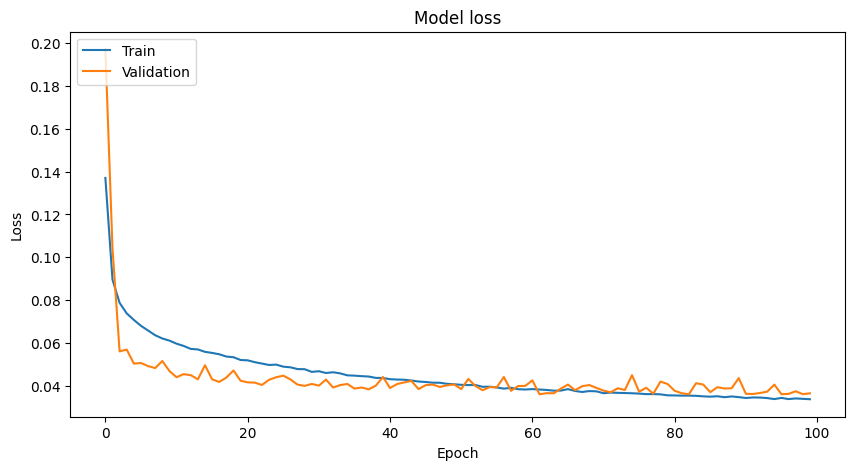

In [ ]:

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

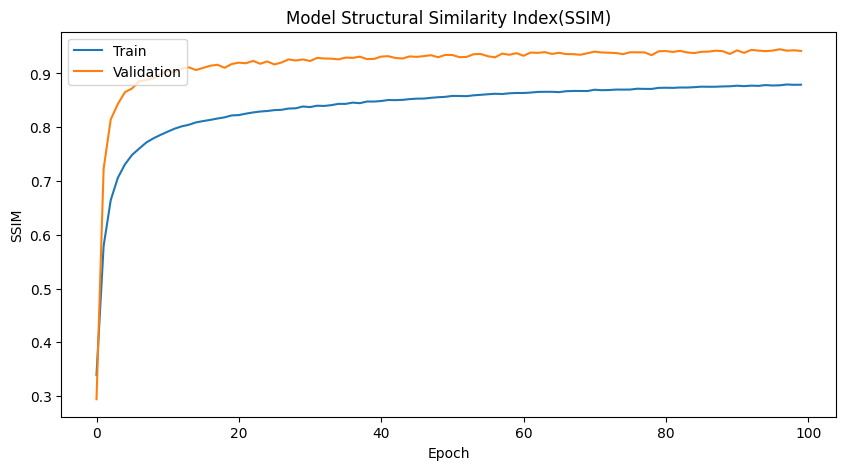

In [ ]:

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['ssim_metric'])
plt.plot(history.history['val_ssim_metric'])
plt.title('Model Structural Similarity Index(SSIM)')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:

import matplotlib.pyplot as plt

# Take a batch from the test dataset
for hazy_batch, clear_batch in test_dataset.take(1):
  # Predict using the model
  predicted_batch = model.predict(hazy_batch)

  # Plot the images
  for i in range(min(batch_size, 4)): # Adjust to display more/less images
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(hazy_batch[i])
      plt.title("Hazy Image")

      plt.subplot(1, 3, 2)
      plt.imshow(predicted_batch[i])
      plt.title("Predicted Dehazed Image")

      plt.subplot(1, 3, 3)
      plt.imshow(clear_batch[i])
      plt.title("Actual Dehazed Image")

      plt.show()

In [ ]:

import matplotlib.pyplot as plt

# Take a batch from the test dataset
for hazy_batch, clear_batch in test_dataset.take(1):
  # Predict using the model
  predicted_batch = model.predict(hazy_batch)

  # Plot the images
  for i in range(min(batch_size, 16)): # Adjust to display more/less images
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(hazy_batch[i])
      plt.title("Hazy Image")

      plt.subplot(1, 3, 2)
      plt.imshow(predicted_batch[i])
      plt.title("Predicted Dehazed Image")

      plt.subplot(1, 3, 3)
      plt.imshow(clear_batch[i])
      plt.title("Actual Dehazed Image")

      plt.show()

In [ ]:

import matplotlib.pyplot as plt

# Take a batch from the test dataset
for hazy_batch, clear_batch in dataset.take(1):
  # Predict using the model
  predicted_batch = model.predict(hazy_batch)

  # Plot the images
  for i in range(min(batch_size, 4)): # Adjust to display more/less images
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(hazy_batch[i])
      plt.title("Hazy Image")

      plt.subplot(1, 3, 2)
      plt.imshow(predicted_batch[i])
      plt.title("Predicted Dehazed Image")

      plt.subplot(1, 3, 3)
      plt.imshow(clear_batch[i])
      plt.title("Actual Dehazed Image")

      plt.show()

In [ ]:

import matplotlib.pyplot as plt

# Take a batch from the test dataset
for hazy_batch, clear_batch in dataset.take(1):
  # Predict using the model
  predicted_batch = model.predict(hazy_batch)

  # Plot the images
  for i in range(min(batch_size, 16)): # Adjust to display more/less images
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(hazy_batch[i])
      plt.title("Hazy Image")

      plt.subplot(1, 3, 2)
      plt.imshow(predicted_batch[i])
      plt.title("Predicted Dehazed Image")

      plt.subplot(1, 3, 3)
      plt.imshow(clear_batch[i])
      plt.title("Actual Dehazed Image")

      plt.show()

In [ ]:

import numpy as np
psnr_values = []
for hazy_batch, clear_batch in dataset:
  predictions = model.predict(hazy_batch)
  for i in range(predictions.shape[0]):
    psnr_value = tf.image.psnr(clear_batch[i], predictions[i], max_val=1.0).numpy()
    psnr_values.append(psnr_value)

average_psnr = np.mean(psnr_values)
print("Average PSNR on training dataset:", average_psnr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [ ]:

import numpy as np
psnr_values = []
for hazy_batch, clear_batch in test_dataset:
  predictions = model.predict(hazy_batch)
  for i in range(predictions.shape[0]):
    psnr_value = tf.image.psnr(clear_batch[i], predictions[i], max_val=1.0).numpy()
    psnr_values.append(psnr_value)

average_psnr = np.mean(psnr_values)
print("Average PSNR on testing dataset:", average_psnr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [ ]:
model.save('dehaze_model.keras')

In [ ]:

import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/dehaze_model.keras', custom_objects={'ImprovedFusionLayer': ImprovedFusionLayer, 'CustomAttentionLayerWithPositionalEncoding':CustomAttentionLayerWithPositionalEncoding, 'ssim_metric':ssim_metric})
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 256, 256, 32)   │          1,344 │ conv2d_1[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 32)   │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 64)   │          4,736 │ conv2d_2[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 64)   │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 64, 64, 128)    │         17,664 │ conv2d_3[0][0]         │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 2,463,595 (9.40 MB)

 Trainable params: 820,899 (3.13 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1,641,800 (6.26 MB)

In [ ]:
model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 524ms/step - loss: 0.0368 - ssim_metric: 0.9425


[0.03655153140425682, 0.9422035217285156]

In [ ]:
model.evaluate(dataset)

375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - loss: 0.0315 - ssim_metric: 0.9052


[0.031430698931217194, 0.9051805734634399]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/dehaze_model.keras /content/drive/MyDrive

Mounted at /content/drive
